Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from sklearn.metrics import mean_absolute_error
from torch.nn import Module, LSTM, Linear
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
import pandas as pd
import matplotlib.pyplot as plt

/Users/nicolae.mogage/Uni/Masters/Semester 1/Advanced Methods in Data Analysis/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model creation

In [2]:
class Net(Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(Net, self).__init__()
        self.lstm = LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = Linear(hidden_size * 2, num_classes)
        
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

Sentiment Analysis Dataset and declaration

In [24]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        label = self.dataframe.iloc[idx, 0] 
        message = self.dataframe.iloc[idx, 1]  

        encoding = self.tokenizer(
            message,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # input_ids = encoding['input_ids'].squeeze().float()
        input_ids = encoding['input_ids'].float()
        return input_ids, torch.tensor(label, dtype=torch.long)

In [25]:
sentiment_analysis_csv = pd.read_csv('FirstReportData/sentiment_analysis.csv', header=None, encoding='ISO-8859-1')

train_data, test_data = train_test_split(sentiment_analysis_csv, test_size=0.3, random_state=42, shuffle=True)

print("Training data size:", len(train_data))
print("Testing data size:", len(test_data))

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = SentimentAnalysisDataset(train_data, tokenizer, max_length=128)
test_dataset = SentimentAnalysisDataset(test_data, tokenizer, max_length=128)

Training data size: 1120000
Testing data size: 480000


In [26]:
device = torch.device("mps")

input_size = 128
hidden_size = 64
num_layers = 2
num_classes = 2

model = Net(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Weather Forecast Dataset and declaration

In [3]:
class WeatherForecastDataset(Dataset):
    def __init__(self, sequence_length=5):
        data = pd.read_csv('FirstReportData/weather_forecast_cleaned.csv')
        data = data.dropna()
        temperatures = data["T (degC)"].values.reshape(-1, 1)
        features = data.drop(columns=["T (degC)"]).values
        
        self.sequences = []
        self.targets = []
        
        for i in range(len(features) - sequence_length):
            self.sequences.append(features[i:i + sequence_length])
            self.targets.append(temperatures[i + sequence_length])
            
        self.sequences = torch.tensor(self.sequences, dtype=torch.float32)
        self.targets = torch.tensor(self.targets, dtype=torch.float32)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]


In [4]:
device = torch.device("mps")
weather_forecast_dataset = WeatherForecastDataset(7)

train_dataset, test_dataset = train_test_split(weather_forecast_dataset, test_size=0.2, random_state=0, shuffle=False)

input_size = 11
hidden_size = 32
num_layers = 2
num_classes = 1

model = Net(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/var/folders/gg/xybng_gj2rz3ltl94z9r_c59xzqsfn/T/ipykernel_18070/3175361563.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  self.sequences = torch.tensor(self.sequences, dtype=torch.float32)


Crypto Currency Dataset and declaration

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler_in = MinMaxScaler(feature_range=(0, 1))
scaler_out = MinMaxScaler(feature_range=(0, 1))
class CryptoDataset(Dataset):
    def __init__(self, data_file, sequence_length=3):
        data = pd.read_csv(data_file) 
        prices = data['Close'].values.reshape(-1, 1)
        features = data.drop(columns=['Date', 'Close', 'Currency']).values

        prices = scaler_out.fit_transform(prices)
        features = scaler_in.fit_transform(features)

        self.sequences = []
        self.targets = []
        for i in range(len(prices) - sequence_length):
            self.sequences.append(features[i:i + sequence_length])
            self.targets.append(prices[i + sequence_length])
            
        self.sequences = torch.tensor(self.sequences, dtype = torch.float32)
        self.targets = torch.tensor(self.targets, dtype = torch.float32)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

In [10]:
crypto = CryptoDataset('FirstReportData/CryptoCurrencies/Elrond.csv', 14)
train_data, test_data = train_test_split(crypto, test_size=0.2, random_state=0, shuffle=False)
device = torch.device("mps")

input_size = crypto.sequences.shape[2]
hidden_size = 64
num_layers = 3
num_classes = 1

model = Net(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_dataloader = DataLoader(train_data, batch_size=50, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=50, shuffle=False)

Urban Sound Dataset and declaration

Training and evaluation functions

In [13]:
def train(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0
    
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)


def evaluate(model, dataloader, criterion, problem_type='classification', plot=False, is_transformed=False):
    model.eval()
    total_loss = 0
    
    if problem_type == 'classification':
        correct = 0    
    else:
        total_r2_score = 0
        
    actuals = []
    predictions = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            if problem_type == 'classification':
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
            else:
                predicted = outputs.squeeze()
                total_r2_score += mean_absolute_error(outputs.cpu(), labels.cpu())

            if is_transformed:
                predicted = scaler_out.inverse_transform(predicted.cpu().numpy().reshape(-1, 1))
                labels = scaler_out.inverse_transform(labels.cpu().numpy().reshape(-1, 1))
            else:
                predicted = predicted.cpu().numpy()
                labels = labels.cpu().numpy()

            predictions.extend(predicted)
            actuals.extend(labels)
            total_loss += loss.item()

    if plot:
        plt.figure(figsize=(12, 6))
        plt.plot(actuals, label='Actual Prices', color='blue', alpha=0.7)
        plt.plot(predictions, label='Predicted Prices', color='orange', linestyle='--', alpha=0.7)
        plt.title('Actual vs Predicted Prices')
        plt.xlabel('Sample Index')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

    avg_loss = total_loss / len(dataloader)
    if problem_type == 'classification':
        accuracy = correct / len(dataloader.dataset)
        return avg_loss, accuracy
    else:        
        avg_r2_score = total_r2_score / len(dataloader)
        return avg_loss, avg_r2_score


Epoch [1/10], Train Loss: 4.6370, Test Loss: 7.3489, Test Accuracy: 1.8613
Epoch [2/10], Train Loss: 3.6529, Test Loss: 3.5942, Test Accuracy: 1.3040
Epoch [3/10], Train Loss: 1.9850, Test Loss: 1.8081, Test Accuracy: 0.8293
Epoch [4/10], Train Loss: 1.4664, Test Loss: 3.1853, Test Accuracy: 1.1328
Epoch [5/10], Train Loss: 1.0752, Test Loss: 1.2544, Test Accuracy: 0.7226
Epoch [6/10], Train Loss: 0.8382, Test Loss: 1.7826, Test Accuracy: 0.7122
Epoch [7/10], Train Loss: 0.8855, Test Loss: 1.7139, Test Accuracy: 0.7786
Epoch [8/10], Train Loss: 0.7496, Test Loss: 1.4285, Test Accuracy: 0.7030
Epoch [9/10], Train Loss: 0.6265, Test Loss: 1.1033, Test Accuracy: 0.6225
Epoch [10/10], Train Loss: 0.6889, Test Loss: 0.8021, Test Accuracy: 0.5048


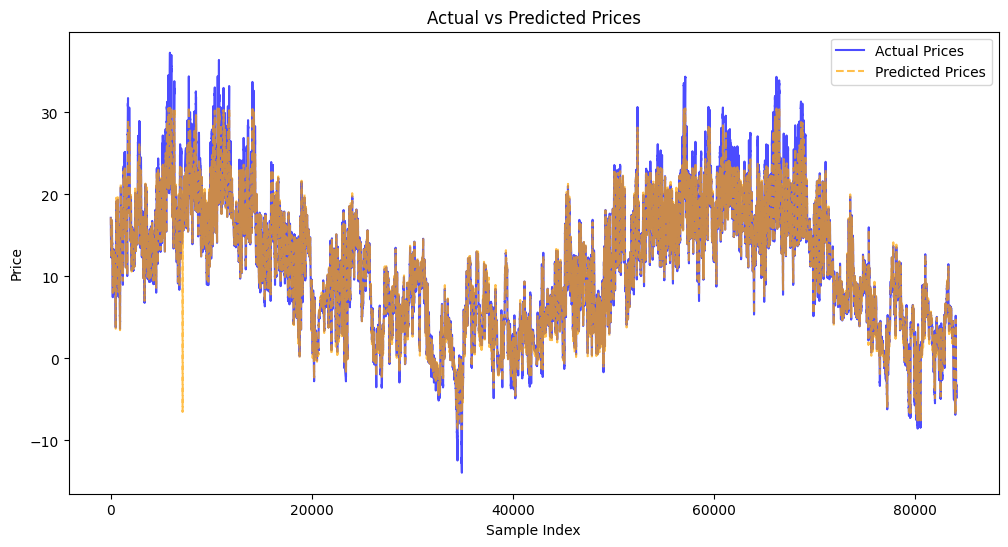

(0.8021174010290375, np.float32(0.5048384))

In [8]:
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train(model, train_dataloader, criterion, optimizer)
    test_loss, test_accuracy = evaluate(model, test_dataloader, criterion, "regression", plot=False)

    print(
        f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

evaluate(model, test_dataloader, criterion, "regression", plot=True)


Epoch [1/25], Train Loss: 0.0872, Test Loss: 0.0140, Test Accuracy: 0.0865
Epoch [2/25], Train Loss: 0.0712, Test Loss: 0.0088, Test Accuracy: 0.0588
Epoch [3/25], Train Loss: 0.0575, Test Loss: 0.0064, Test Accuracy: 0.0630
Epoch [4/25], Train Loss: 0.0463, Test Loss: 0.0071, Test Accuracy: 0.0775
Epoch [5/25], Train Loss: 0.0383, Test Loss: 0.0105, Test Accuracy: 0.0965
Epoch [6/25], Train Loss: 0.0338, Test Loss: 0.0154, Test Accuracy: 0.1141
Epoch [7/25], Train Loss: 0.0323, Test Loss: 0.0193, Test Accuracy: 0.1259
Epoch [8/25], Train Loss: 0.0318, Test Loss: 0.0210, Test Accuracy: 0.1307
Epoch [9/25], Train Loss: 0.0313, Test Loss: 0.0211, Test Accuracy: 0.1308
Epoch [10/25], Train Loss: 0.0303, Test Loss: 0.0205, Test Accuracy: 0.1289
Epoch [11/25], Train Loss: 0.0291, Test Loss: 0.0198, Test Accuracy: 0.1266
Epoch [12/25], Train Loss: 0.0277, Test Loss: 0.0192, Test Accuracy: 0.1246
Epoch [13/25], Train Loss: 0.0262, Test Loss: 0.0185, Test Accuracy: 0.1227
Epoch [14/25], Train 

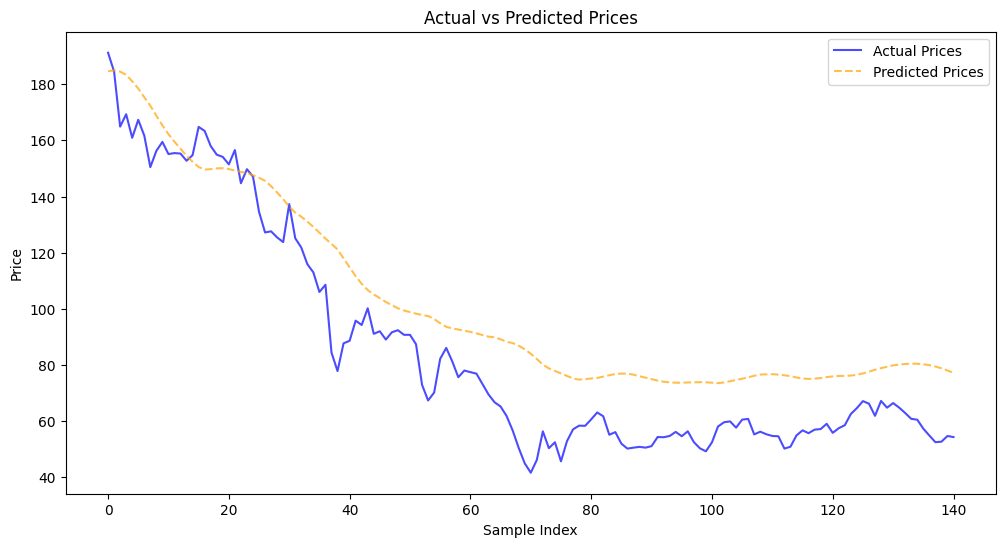

(0.0016055703939249117, np.float32(0.03623356))

In [14]:
num_epochs = 25
for epoch in range(num_epochs):
    train_loss = train(model, train_dataloader, criterion, optimizer)
    test_loss, test_accuracy = evaluate(model, test_dataloader, criterion, "regression", plot=False, is_transformed=True)

    print(
        f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

evaluate(model, test_dataloader, criterion, "regression", plot=True, is_transformed=True)


Epoch [1/1], Train Loss: 0.6875, Test Loss: 0.6873, Test Accuracy: 0.5473


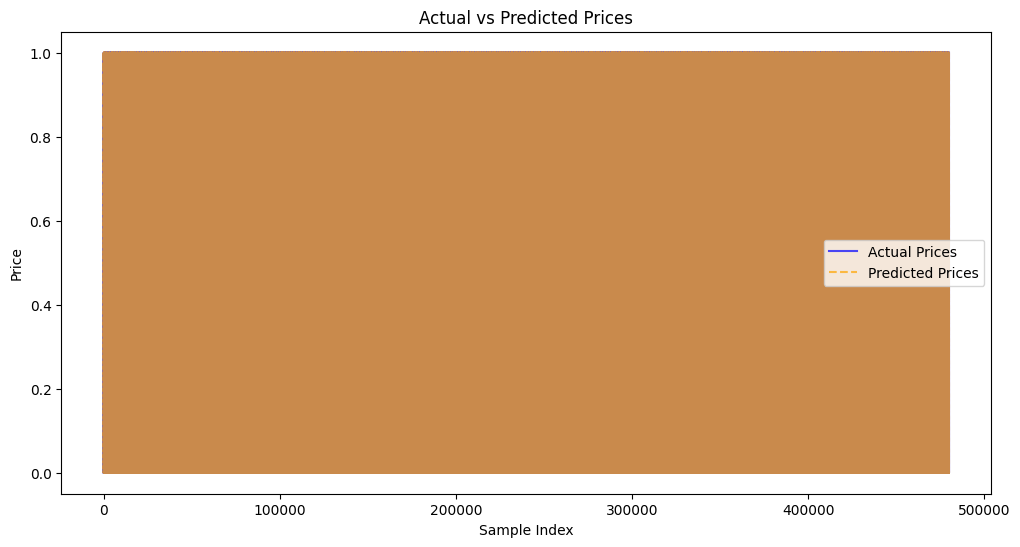

(0.6872941808700561, 0.5473333333333333)

In [28]:
num_epochs = 1
for epoch in range(num_epochs):
    train_loss = train(model, train_dataloader, criterion, optimizer)
    test_loss, test_accuracy = evaluate(model, test_dataloader, criterion, "classification", plot=False)

    print(
        f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


Manual testing

In [79]:
# torch.save(model.state_dict(), 'FirstReportData/sentiment_analysis_model.pth')

model = Net(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes).to(device)
model.load_state_dict(torch.load('FirstReportData/sentiment_analysis_model.pth'))
model.eval()
message = "i loved it here"
encoding = tokenizer(
    message,
    add_special_tokens=True,
    max_length=128,
    padding='max_length',
    truncation=False,
    return_tensors='pt'
)

output = model(encoding['input_ids'].float().to(device))
_, predicted = torch.max(output, 1)
print("Predicted:", predicted.item())


Predicted: 0


/var/folders/gg/xybng_gj2rz3ltl94z9r_c59xzqsfn/T/ipykernel_59828/1505535154.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('FirstReport

In [19]:
test_loss, test_accuracy = evaluate(model, test_dataloader, criterion)

print(
    f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.0836, Test Accuracy: 0.2891
